Using device: cuda


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/330M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 23410
    })
})


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s] 


Epoch 1/5
--------------------
Train Loss: 0.1138 Acc: 0.9564
Val Loss: 0.0861 Acc: 0.9648

Epoch 2/5
--------------------
Train Loss: 0.0710 Acc: 0.9722
Val Loss: 0.0688 Acc: 0.9733

Epoch 3/5
--------------------
Train Loss: 0.0603 Acc: 0.9784
Val Loss: 0.0986 Acc: 0.9607

Epoch 4/5
--------------------
Train Loss: 0.0486 Acc: 0.9818
Val Loss: 0.0735 Acc: 0.9746

Epoch 5/5
--------------------
Train Loss: 0.0425 Acc: 0.9849
Val Loss: 0.0824 Acc: 0.9701



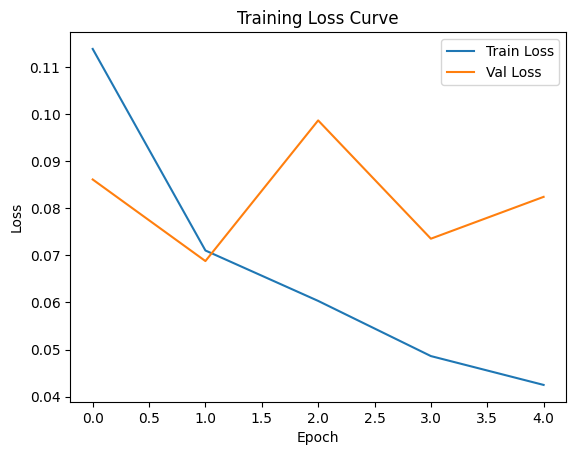

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

# ----------------------
# 1. 配置设备
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------
# 2. 加载 Hugging Face 数据集
# ----------------------
dataset = load_dataset("microsoft/cats_vs_dogs")
print(dataset)

# ----------------------
# 3. 定义 PyTorch Dataset
# ----------------------
class CatsDogsDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = self.dataset[idx]['image']  # 已经是 PIL.Image.Image 类型
        img = img.convert('RGB')
        label = self.dataset[idx]['labels']
        if self.transform:
            img = self.transform(img)
        return img, label

# ----------------------
# 4. 数据增强与预处理
# ----------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
              [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
              [0.229, 0.224, 0.225])
])

# ----------------------
# 5. 构建 Dataset 和 DataLoader
# ----------------------
# Hugging Face 数据集没有明确定义 train/val，手动划分
split_ratio = 0.8
dataset_size = len(dataset['train'])
train_size = int(split_ratio * dataset_size)
val_size = dataset_size - train_size

full_dataset = CatsDogsDataset(dataset['train'], transform=train_transform)
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform  # 验证集不做随机增强

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ----------------------
# 6. 构建模型
# ----------------------
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 二分类
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# ----------------------
# 7. 训练函数
# ----------------------
def train_model(model, criterion, optimizer, num_epochs=5):
    train_loss_history = []
    val_loss_history = []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-"*20)

        # 训练
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # 验证
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        val_loss_history.append(epoch_loss)
        print(f"Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}\n")

    return train_loss_history, val_loss_history

# ----------------------
# 8. 开始训练
# ----------------------
train_loss, val_loss = train_model(model, criterion, optimizer, num_epochs=5)

# ----------------------
# 9. 绘制训练曲线
# ----------------------
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()
